This notebook goes over the details of how we go from a set of readings back to an image. It will cover three different topologies, each of which has been used in differnt types of Computed Tomography. We can take readings to simulate each of these three scanning methodologies.

## Parallel beam

Introduce the radon transform

Beams are passed from one or more emitters to one or more detectors, with all beams in parallel. Then this is repeated again, from a different angle. We end up with a set of readings for each angle theta, and this collection of sets of readings is called a sinogram.

In [1]:
from image_util import *
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

%matplotlib inline

In [2]:
# Draw_parallel <<< TODO Add parallel radon example

## Fan Beam #1

Here, a single emitter sends out light, and an array of detectors record the readings. 

[9945, 33405, 32385, 31875, 31875, 32385, 33150, 34680]


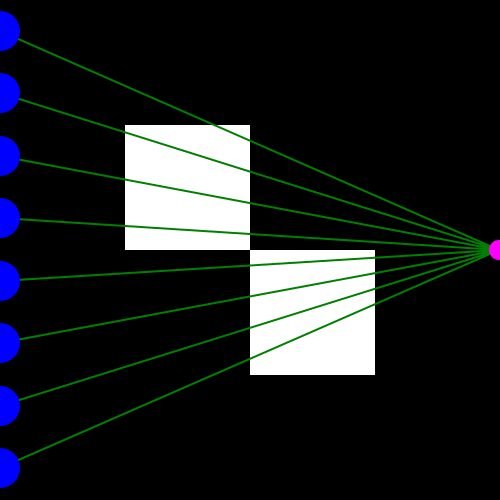

In [3]:
es = [{'r':1, 'a':0}]
ds = []
for i in range(8):
    ds.append({'r':(1+((i-3.5)/4)**2)**0.5, # uniform vertical distance between detectors
               'a':math.pi+math.atan((i-3.5)/4)})

# Simulate ligth passing along the differnt rays
tis, tii, x, y = p1(500, 500)
print(get_paths(tii, ds, es,500, 500))

# Draw the figure
s = draw_des_surf(tis, ds, es, 500, 500)
s.write_to_png('test.png')
Image('test.png')

We can simulate this sort of arrangement using the Astra toolbox:

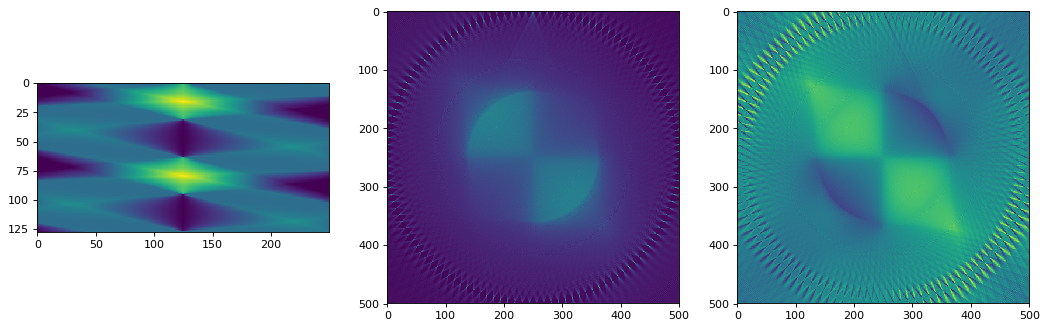

In [4]:
# Create a 500 by 500 pixel space to work within
vol_geom = astra.create_vol_geom(500, 500)

# Set up the angles (views) - 128 different views
angles = np.linspace(0,2*math.pi,128);

# Create a projection object. If we follow the image above (but with 250 sensors) we'll have the detector plane and emitter 
# both at 250px from the center. We're replicating the 'fanflat' arrangement
proj_geom= astra.create_proj_geom('fanflat', 2, 250, angles, 250, 250);
# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane
# (distances in pixels of the )

proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

tis, tii, x, y = p1(500, 500)
P = tii # The image from the diagram above 
sinogram_id, sinogram = astra.create_sino(P, proj_id)

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(sinogram) #<< Set title

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bp) #<<<< 

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data2d.get(rec_id)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(rec)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

You can see the reconstructions aren't great. That's because (as you can see in the diagram) some parts of the object don't fit within the fan beam. Moving the detectors and emitters away helps - here it is with both at double the previous distance:

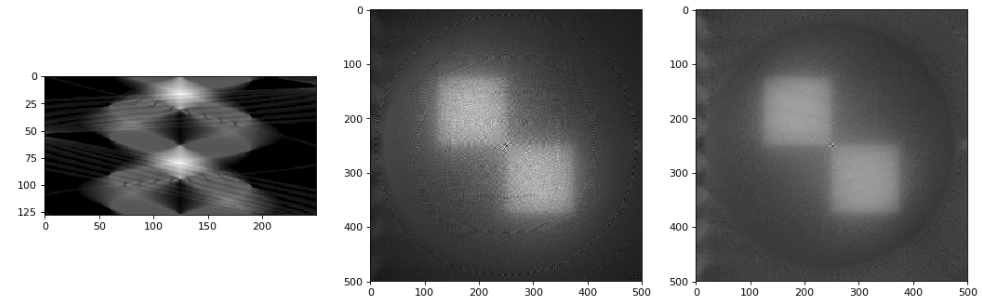

In [5]:
Image('Fanbeam_reconstruction_further_away.png') # Change colour map

We can get the sinogram in another way - with our simulator. We specify the emitter and detector arrangement and the rotate these around through the different angles theta.

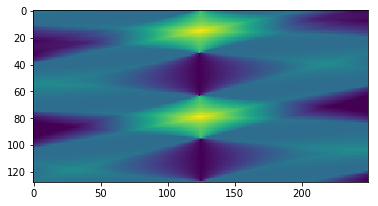

In [6]:
es = [{'r':1, 'a':0}]
ds = []
for i in range(250):
    ds.append({'r':(1+((i-124.5)/125)**2)**0.5,
               'a':math.pi+math.atan((i-124.5)/125)})
tis, tii, x, y = p1(500, 500)
rotate_des(ds, es, math.pi/2)

paths = []
for i in range(128):
    paths.append(get_paths(tii, *rotate_des(ds, es, 2*math.pi/128),500, 500))

plt.imshow(paths)

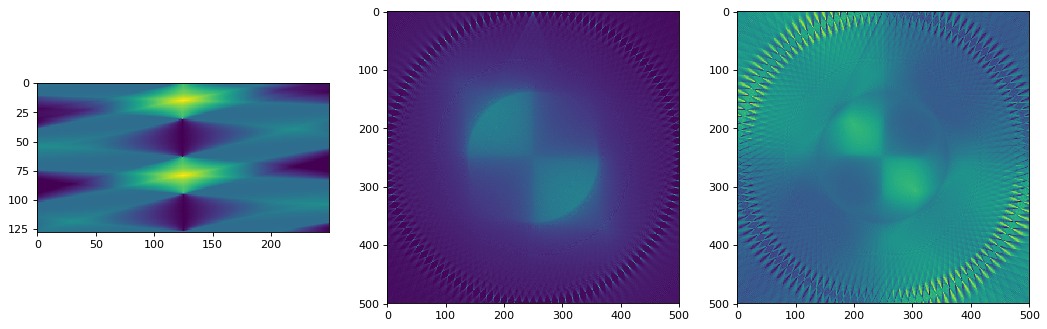

In [7]:
# We can use astra to reconstruct the image based on our paths like so:
# Create a 500 by 500 pixel space to work within
vol_geom = astra.create_vol_geom(500, 500)

# Set up the angles (views) - 128 different views
angles = np.linspace(0,2*math.pi,128);

# Create a projection object. If we follow the image above (but with 250 sensors) we'll have the detector plane and emitter 
# both at 250px from the center. We're replicating the 'fanflat' arrangement
proj_geom= astra.create_proj_geom('fanflat', 2, 250, angles, 250, 250);
# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane
# (distances in pixels of the )

proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(paths))

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(paths) #<< Set title

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bp) #<<<< 

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data2d.get(rec_id)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(rec)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

## Fan Beam #2

This is what we get from the rotating table. Detectors in a ring, spaced at regular angles like so:

[0, 0, 26265, 25500, 18215, 18725, 0, 0]


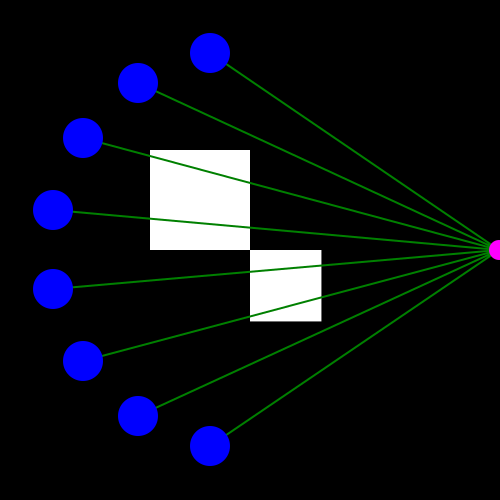

In [8]:
es = [{'r':1, 'a':0}]
ds = []
for i in range(8):
    ds.append({'r':0.8,
               'a':math.pi/2 + math.pi*(i+0.5)/8})

# Simulate ligth passing along the differnt rays
tis, tii, x, y = p2(500, 500)
print(get_paths(tii, ds, es,500, 500))

# Draw the figure
s = draw_des_surf(tis, ds, es, 500, 500)
s.write_to_png('test.png')
Image('test.png')



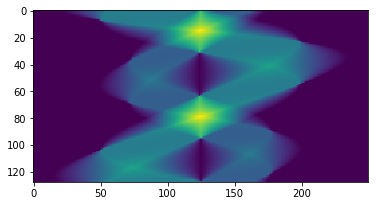

In [9]:
es = [{'r':1, 'a':0}]
ds = []
for i in range(250):
    ds.append({'r':0.8,
               'a':math.pi/2 + math.pi*(i+0.5)/250}) 

tis, tii, x, y = p2(500, 500)
rotate_des(ds, es, math.pi/2)

paths = []
for i in range(128):
    paths.append(get_paths(tii, *rotate_des(ds, es, 2*math.pi/128),500, 500))

plt.imshow(paths)

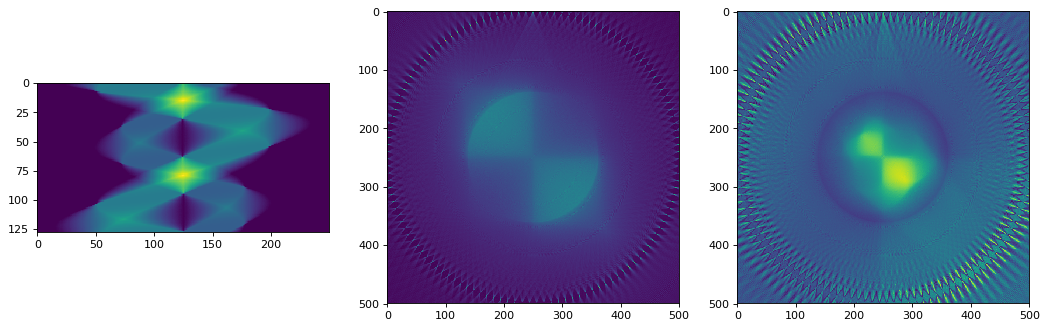

In [10]:
vol_geom = astra.create_vol_geom(500, 500)
angles = np.linspace(0,2*math.pi,128);
proj_geom= astra.create_proj_geom('fanflat', 2, 250, angles, 250, 250);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(paths))

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(paths) #<< Set title

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bp) #<<<< 

rec_id = astra.data2d.create('-vol', vol_geom)
                             
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data2d.get(rec_id)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(rec)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

Now here's the nifty thing. We remap the curved detector locations to points on a line, then use interpolation to figure out what the reading would be for a given position on the line (coresponding to the detector location in fan beam #1 setup). We can then use the reconstruction algorithm the way it was intended

In [11]:
# Caution: this seems standard
theta = np.linspace(0, math.pi, 160)
print(theta[159])
# This is what the robot does:
# theta = np.asarray([math.pi*i/160 for i in range(160)])
# print(theta[159])

R = 250*0.8 #(70mm)
D = 250 #(95mm)

theta = np.linspace(0, math.pi, 250)
alpha = np.asarray([R*math.sin(t-math.pi/2)/(R**2 + D**2)**0.5 for t in theta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

from scipy import interpolate

r2 = []
tau_new = np.linspace(-250, 250, 250) # Can change bounds. GOod to stick within max

for r in paths:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    r2.append(f(tau_new))


3.141592653589793


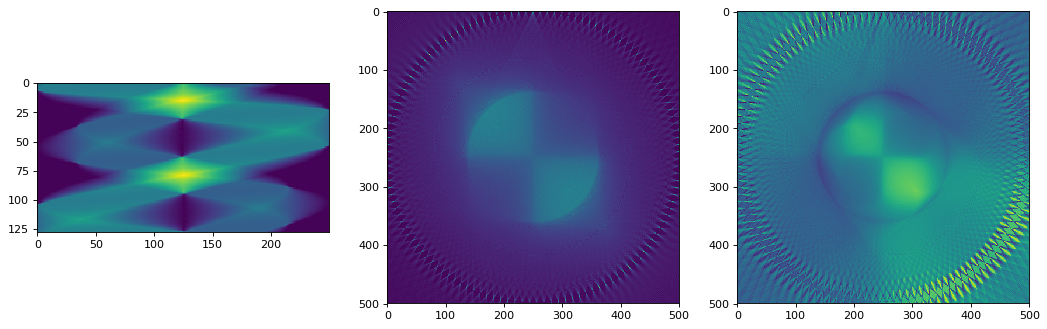

In [12]:
vol_geom = astra.create_vol_geom(500, 500)
angles = np.linspace(0,2*math.pi,128);
proj_geom= astra.create_proj_geom('fanflat', 2, 250, angles, 250, 250);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(r2))

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(r2) #<< Set title

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bp) #<<<< 

rec_id = astra.data2d.create('-vol', vol_geom)
                             
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data2d.get(rec_id)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(rec)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

Since tau actually goes from -324 to 324, we can get a larger equivalent line of sensors. Check it!

In [13]:
r3 = []
tau_new = np.linspace(-320, 320, 250) # Can change bounds. GOod to stick within max

for r in paths:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    r3.append(f(tau_new))


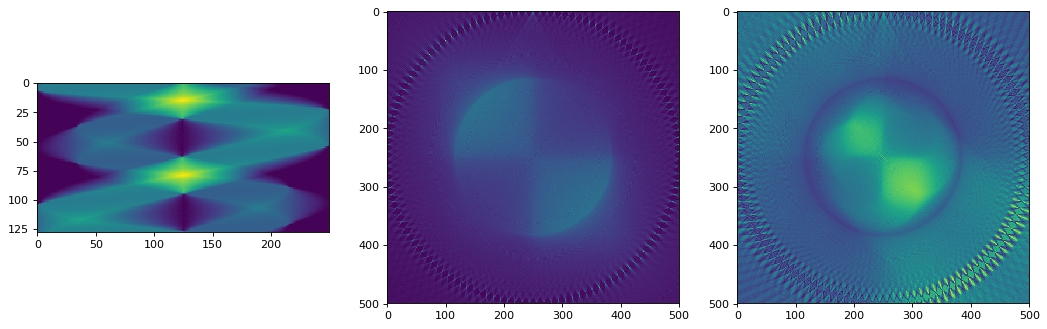

In [14]:
vol_geom = astra.create_vol_geom(500, 500)
angles = np.linspace(0,2*math.pi,128);
proj_geom= astra.create_proj_geom('fanflat', 640/250, 250, angles, 250, 250);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(r3))

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(r2) #<< Set title

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bp) #<<<< 

rec_id = astra.data2d.create('-vol', vol_geom)
                             
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data2d.get(rec_id)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(rec)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

In [15]:
dist_d = 0.8 #(70mm)
dist_e = 1 #(95mm)
nviews = 160
ndetectors = 250
IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2

es = [{'r':1, 'a':0}]
ds = []
for i in range(ndetectors):
    ds.append({'r':0.8,
               'a':math.pi/2 + math.pi*(i+0.5)/ndetectors}) 

tis, tii, x, y = p2(IMSIZE, IMSIZE)
rotate_des(ds, es, math.pi/2)

paths = []
for i in range(nviews):
    paths.append(get_paths(tii, *rotate_des(ds, es, 2*math.pi/nviews),IMSIZE, IMSIZE))

# plt.imshow(paths)

theta = np.linspace(0, math.pi, nviews)

beta = np.linspace(0, math.pi, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

from scipy import interpolate

r2 = []
tau_new = np.linspace(-250, 250, ndetectors) # Can change bounds. GOod to stick within max

for r in paths:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    r2.append(f(tau_new))

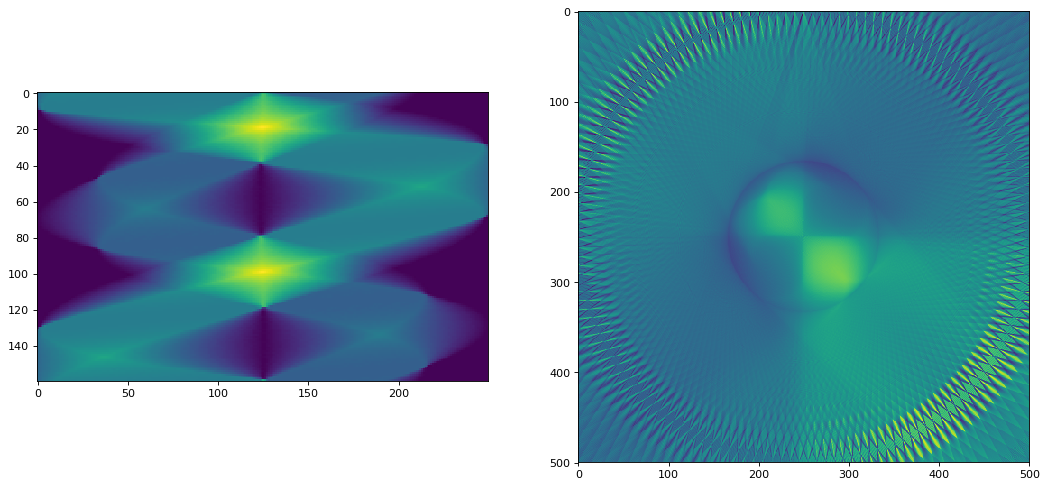

In [16]:
reconstruct(r2, nviews, ndetectors, IMSIZE, dist_e, dist_d)

(32, 160)


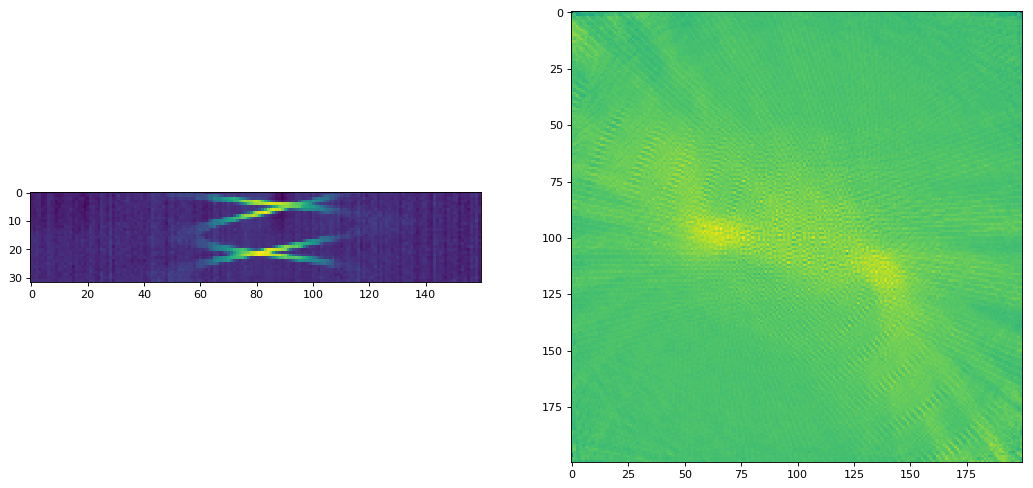

In [17]:
import pandas as pd
bb = pd.read_csv('12Aug_BASE_two_pens.csv')
br = pd.read_csv('12Aug_R_two_pens.csv')
readings = np.asarray(br)
base = np.asarray(bb).T
print(readings.shape)
for r in range(len(readings)):
    readings[r] = readings[r]-base
    
reconstruct(readings, 32, 160, 200, 90/50, 70/50)


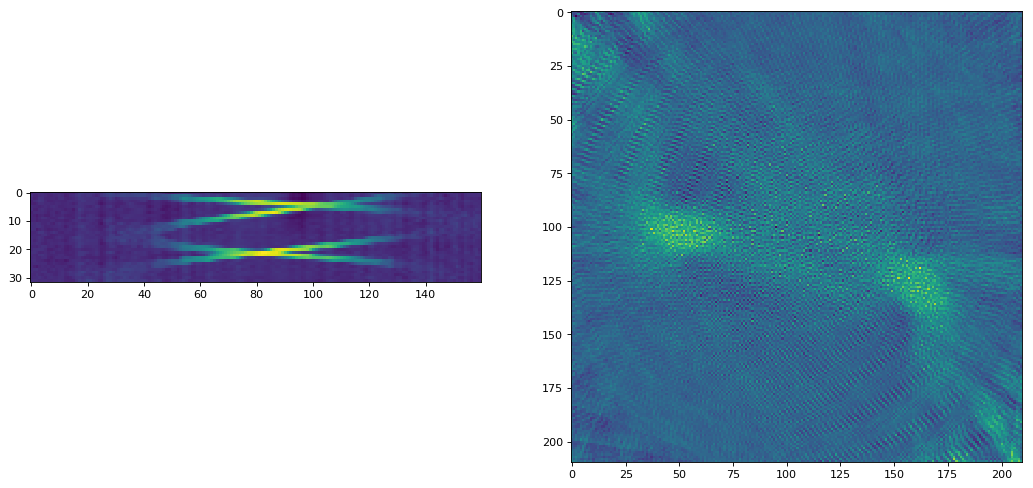

In [18]:
def reconstruct(sin, nviews, ndetectors, IMSIZE, dist_e, dist_d):
    # Sinogram, nv, nd, w and h, dist to e (1 = imsize/2), dist to d
    vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
    angles = np.linspace(0,2*math.pi,nviews);
    proj_geom= astra.create_proj_geom('fanflat', 640/IMSIZE, ndetectors, angles, IMSIZE*dist_e/2, IMSIZE*dist_d/2);
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(sin))


    plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(sin) #<< Set title

    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict('SIRT')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, 20)

    # Get the result
    rec = astra.data2d.get(rec_id)
    ax3 = plt.subplot(1, 2, 2)
    ax3.imshow(rec)

    # Clean up.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    
    return rec



dist_d = 0.8 #(70mm)
dist_e = 1 #(95mm)
nviews = 32
ndetectors = 160
IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2

beta = np.linspace(0, math.pi, 160)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-250, 250, ndetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))
    
rec = reconstruct(readings2, 32, 160, 210, 90/50, 70/50)

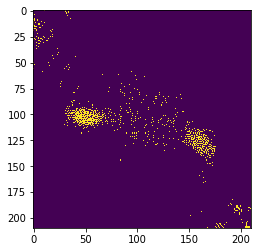

In [19]:
idx = rec[:,:]>13
plt.imshow(idx)

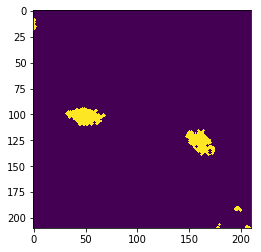

In [20]:
from skimage import morphology
idx = rec[:,:]>13
d1 = morphology.dilation(idx)
e1 = morphology.erosion(d1)
e2 = morphology.erosion(e1)
d2 = morphology.dilation(e2)
plt.imshow(d2)

# Putting it all togehter for future reference

Given an array length n_views, each with n_detectors worth of readings, with the detectors covering 180 degrees opposite the emitter, relative distances to the detectors and emitters (relative to the scanned circle)

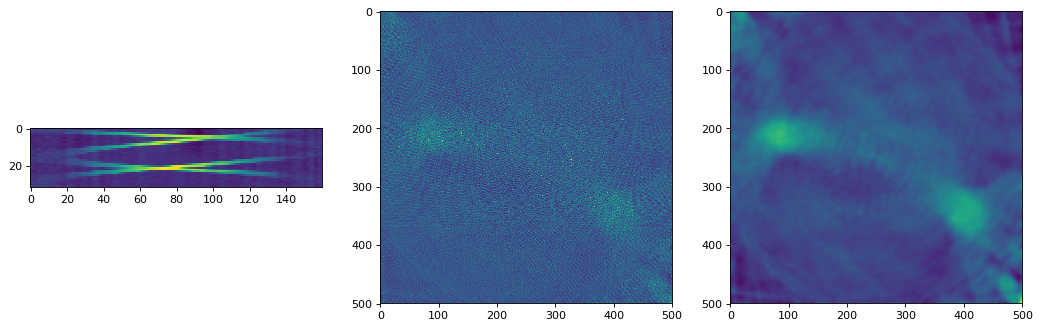

In [21]:
# First, set constants and load data

# Constants
dist_d = 70/50 #(70mm)
dist_e = 95/50 #(95mm)
nviews = 32
ndetectors = 160

# Data
bb = pd.read_csv('12Aug_BASE_two_pens.csv')
br = pd.read_csv('12Aug_R_two_pens.csv')
readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Changing to the #2 geometry and changing distances to pixel distances

IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2


beta = np.linspace(0, math.pi, 160)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)), max(tau), ndetectors) # Can change bounds. GOod to stick within max
tau_new = np.linspace(-(max(tau)/2), 1.3*max(tau)/2, ndetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/ndetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, ndetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(readings2) #<< Set title

rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(blurred)

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

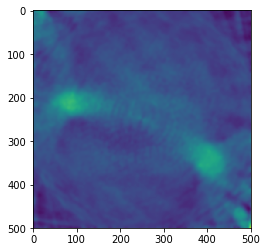

In [22]:
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
plt.imshow(blurred)
plt.savefig('two_pens.png')

In [23]:
np.amax(rec)

25.168928

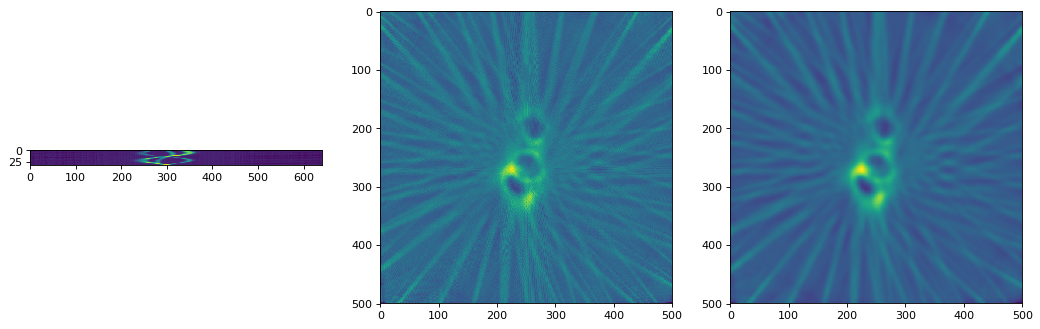

In [24]:
# First, set constants and load data

# Constants
dist_d = 70/50 #(70mm)
dist_e = 95/50 #(95mm)
nviews = 32;
ndetectors = 640

# Data

# br = pd.read_csv('hex_empty_32v_640d.csv')
# bb = pd.read_csv('hex_base.csv')

# br = pd.read_csv('double_cube_empty_32v_640d.csv')
# bb = pd.read_csv('double_cube_empty_base.csv')

# br = pd.read_csv('allen_phantom_1_32v_640d.csv')
# bb = pd.read_csv('allen_phantom_1__base.csv')
# fn = 'allen_phantom_1_32v_640d'

# br = pd.read_csv('two_pens_32v_640d.csv')
# bb = pd.read_csv('two_pens_base.csv')
# fn = 'two_pens_32v_640d'

# br = pd.read_csv('allen_2_640v_640d.csv')
# bb = pd.read_csv('allen_2_base.csv')
# fn = 'allen_2_640v_640d'

br = pd.read_csv('allen_2_32v_640d.csv')
bb = pd.read_csv('allen_2_base.csv')
fn = 'allen_2_32v_640d'

readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Changing to the #2 geometry and changing distances to pixel distances

IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2


beta = np.linspace(0, math.pi, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)), max(tau), ndetectors) # Can change bounds. GOod to stick within max
# Quite often we want to focus in on the regon of interest, so can leave out the extreme bounds:
# tau_new = np.linspace(-(max(tau)/2), max(tau)/3, ndetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/ndetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, ndetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(readings2) #<< Set title

rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(blurred)

plt.savefig(fn + '.png')

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)


New setup, LED_holder_tall and old bracket, back to fixed resistor. 64 views only seeping 400 steps of B. This means we go from math.pi*120/600 to pi - math.pi*120/600 in 400 steps on the B axis.

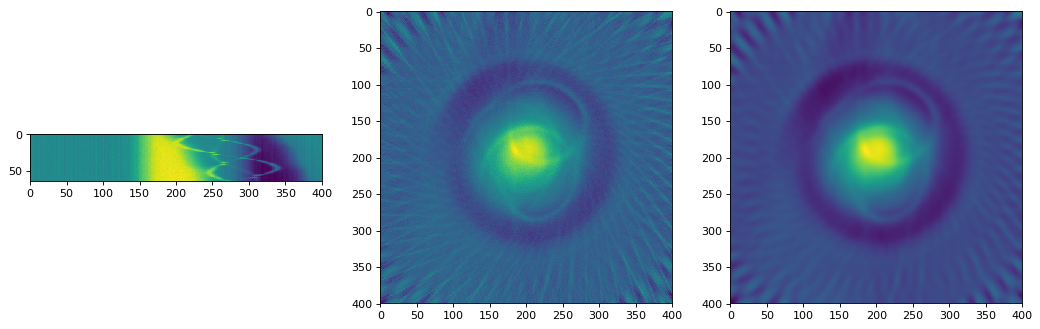

In [25]:
# First, set constants and load data

# Constants
dist_d = 55/50 
dist_e = 85/50 
nviews = 64;
ndetectors = 400

# Data


br = pd.read_csv('nails_64v_400d.csv')
bb = pd.read_csv('lighter_base.csv')
fn = 'lighter'

readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Changing to the #2 geometry and changing distances to pixel distances

IMSIZE = 400
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2


beta = np.linspace(math.pi*120/600, math.pi - math.pi*120/600, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta]) # Check this later
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)), max(tau), ndetectors) # Can change bounds. GOod to stick within max


for r in readings:
    f = interpolate.interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/ndetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, ndetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))


plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(readings2) #<< Set title

rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(blurred)

plt.savefig(fn + '.png')

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)